### Investigate a Dataset Project
# Investigating the Titanic Dataset
----------------

*Name: Fai Alnuhait  *    

*Dataset Link: https://www.kaggle.com/c/titanic*

### Introduction 

This project aims to investigate the Titanic dataset in order to answer the following questions. What factors can be associated with surviving this tragedy? and is there any intresting trends among the passengers? We'll mainly try to answer these questions throughout this report. 

### Loading Dataset 

In [231]:
import pandas as pd
import numpy as np
# Use pandas to load and work with data
data = pd.read_csv('titanic-data.csv')

### Data Cleaning

Before trying to investigate or discover trends in the dataset, I started by checking the quality of it. The following code is used to find any missing data.

In [232]:
# Check if there's any missing data
print('Number of missing values in each variable:')
print('Ids: '+str(data['PassengerId'].isnull().sum()))
print('Survived: '+str(data['Survived'].isnull().sum()))
print('Class: '+str(data['Pclass'].isnull().sum()))
print('Name: '+str(data['Name'].isnull().sum()))
print('Sex: '+str(data['Sex'].isnull().sum()))
print('Age: '+str(data['Age'].isnull().sum()))
print('Siblings and spouses: '+str(data['SibSp'].isnull().sum()))
print('Parents and children: '+str(data['Parch'].isnull().sum()))
print('Ticket: '+str(data['Ticket'].isnull().sum()))
print('Fare: '+str(data['Fare'].isnull().sum()))
print('Cabin: '+str(data['Cabin'].isnull().sum()))
print('Embarkation port: '+str(data['Embarked'].isnull().sum()))

print ('\nNumber of records: '+str(len(data)))

Number of missing values in each variable:
Ids: 0
Survived: 0
Class: 0
Name: 0
Sex: 0
Age: 177
Siblings and spouses: 0
Parents and children: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarkation port: 2

Number of records: 891


>As we can see, We have a serious problem in age as many records have missing age. Cabin in the other side is going to be hard to fix as most of the records are missing to begin with. Therefor, I will not be using this attribute or trying to fix it. Finally, embarkation port missing values seems fixable so I'll try to fill them.

#### 1. Embarkation ports missing records          

Since the missing values in embarkation port is tiny (only two records), I don't think it's worth designing a learning model to fill. Instead, I'll use the mean to fill up these two missing records as it wouldn't affect the distribution of the data.        

Knowing that the ports is a categorical data, I'll convert it to numerical and then find the rounded mean which will be used to fill missing data.

In [233]:
# Filling embarkation port missing values 
mapping = {'S': 0, 'C': 1, 'Q': 2}

# conversion function        
def convert (field):
    return mapping[field]

ports = data['Embarked'].dropna().apply(convert)
mean = int(sum(ports)/len(ports))

# find the port letter
for key, value in mapping.items():
    if value == mean:
        port = key 

# fill missing data with the port (mean letter)
data['Embarked'] = data['Embarked'].fillna(port)


#### 2. Age missing records      

In order to fix the age issue, I will use other attributes to guess or predict the missing values specifically the following attribute: fare, alone, sex, class, survived, embarkation port and title which I extracted from the name in the code below. Other features were eliminated as they were clearly useless (Id is unique and therefore cannot be used, Ticket does not have a standard format which will make it useless as well, Cabin has massive amount of missing data, and finally parents/children and siblings/spouses were interpreted in the alone feature to make it easier to manipulate.   

In [234]:
#Extracting title feature

import re
# use regular expression
title_re = re.compile(r'(([a-z])*)\.', re.IGNORECASE)
title = []
#extract the title from name
for index, row in data.iterrows():
    m = title_re.search(row['Name'])
    if m:
        k = m.group(1)
        title.append(k)
# adding the title as a separate feature
data['Title'] = pd.Series(title)

##### Prepare attributes to be used in the learning algorithm     

First, I'm changing the type of Survived attribute to be boolean for easy processing later.

In [235]:
data['Survived'] = data['Survived'] > 0

Second, adding alone feature to be used in prediction instead of the number of parents/children and spouses/siblings.

In [236]:
# Find people with families and people traveling alone
family_travelers = (data['SibSp'] > 0) | (data['Parch'] > 0)
alone_passengers = ~family_travelers
data['alone'] = alone_passengers

Third, we'll convert categorical data to that range. 

In [237]:
# converting to numerical data (sex and title)

mapping['female'] = 0
mapping['male'] = 1 # sex

counter = 0
for item in data['Title']: # title
    if item not in mapping:
        mapping[item]= counter
        counter = counter+1

# reuse the conversion function defined above
data['sex'] = data['Sex'].apply(convert)
data['title'] = data['Title'].apply(convert)
data['port'] = data['Embarked'].apply(convert)

Finally, feature normalization. Knowing that all used features have similar ranges (not greater than 20) except fare, we'll normalize it to be in the range (0-10)



In [238]:
# normalize data (fare)
mini = min(data['Fare'])
rang = max(data['Fare']) - min (data['Fare'])

def norm (number):
    return ((number - mini) / rang ) * 10

data['fare'] = data['Fare'].apply(norm)


#### Predicting age

       
Since we're only trying to fill up missing data, I decided to use a simple algorithm for the prediction. Knowing the age is a continous value, I chose linear regression as it is one on the easiest algorithms to apply. To evaluate the system, I'll use k-fold since it is suitable for small sized data. 

To do so, we need to divide the data into training data and new data (has missing values), and after that reindex the each subset.

In [239]:
# create new set containing tuples without missing age 
index_array = data['Age'].notnull()
data_train = data[index_array]
data_new = data[~index_array]
# reindex
data_train.index = range(0,len(data_train))
data_new.index = range(0,len(data_new))

Now with the data in suitable ranges, divided and ready to be used, we can start implementing the linear regression.

In [240]:
# Define variables
# X is the dataframe containing used features, y is the age attribute
x_dict = {'ones':([1]*len(data_train['Age'])),'survived':data_train['Survived'],'class':data_train['Pclass'],
          'sex':data_train['sex'],'fare':data_train['fare'],'title':data_train['title'],'alone':data_train['alone']}
X = pd.DataFrame(x_dict)
X = X [['ones','alone','class','fare','sex','survived','title']]

y = pd.DataFrame(data_train['Age'])


# cost function using the mean squared error
def cost_func (X, y, theta):
    
    # m is the number of records, n is the number of features in X, h is the prediction, j is cost
    m = len(y)
    h = pd.DataFrame(np.dot(X,theta))
    h = h - y.values
    h = h.pow(2)
    j = (1.0/(2*m)) * (h.sum()[0])
    return (j)


def gradient_descent (X, y, theta):
    
    # set the learning rate (alpha)
    alpha = 0.001
    m = len(y)
    # set the number of loops taken by gradient descent    
    for i in range(0,100000):
        h = pd.DataFrame(np.dot(X,theta))
        h = h - y.values
        h = pd.DataFrame(np.dot(X.transpose(),h))
        theta = theta.subtract((alpha/m)*h)
        
    return theta 

def cross (X, Y):
    
    fold = len(Y)/7
    cost = [0]*7 
    
    for i in range(0,7):
        
        theta = pd.DataFrame([1]*len(X.columns))
        
        # take a subset from the data to be the test set
        if i == 6:
            x_valid = X[int(fold*i):]
            y_valid = Y[int(fold*i):]
        else:
            x_valid = X[int(fold*i):int(fold*(i+1))]
            y_valid = Y[int(fold*i):int(fold*(i+1))]
        
        # the remaining is larning data
        if i == 6:
            x_train = X[0:int(fold*i)]
            y_train = Y[0:int(fold*i)]
        else:
            x_frames = [X[0:int(fold*i)], X[int(fold*(i+1)):]]
            x_train = pd.concat(x_frames)
            y_frames = [Y[0:int(fold*i)], Y[int(fold*(i+1)):]]
            y_train = pd.concat(y_frames)
        
        # Fix indexing issue
        x_valid.index = range(0,len(x_valid))
        y_valid.index = range(0,len(y_valid))
        x_train.index = range(0,len(x_train))
        y_train.index = range(0,len(y_train))
        
        # Train and measure the performance 
        theta = gradient_descent(x_train, y_train, theta)
        cost[i] = cost_func(x_valid, y_valid, theta)
    
    return (sum(cost)/len(cost))


theta = pd.DataFrame([1]*len(X.columns))

print ('cost before learning: '+ str(cost_func(X,y,theta)))
theta = gradient_descent(X, y, theta)
print ('cost after learning: '+ str(cost_func(X,y,theta)))

print ('Performance: ')
print (cross(X, y))

cost before learning: 379.097660813
cost after learning: 78.8932588695
Performance: 
82.4422285288


After constructing the model, I'll apply it to the predict the missing data in age. 

In [282]:
# Apply the model to predict the age 

x_dict = {'ones':([1]*len(data_new['Age'])),'survived':data_new['Survived'],'class':data_new['Pclass'],
          'sex':data_new['sex'],'fare':data_new['fare'],'title':data_new['title'],'alone':data_new['alone']}
X = pd.DataFrame(x_dict)
X = X [['ones','alone','class','fare','sex','survived','title']]

data_new['Age'] = (pd.DataFrame(np.dot(X,theta))).astype(np.float)
data_frames = [data_train, data_new]
data = pd.concat(data_frames)
data.index = range(0,len(data))

### Describing Data

Here, we look at the data to give a brief overview of it. 

##### Where did passengers come from? 
The distribution of passengers among cities is displayed in the following map. 


In [283]:
# first we get the distribution of cities
cities_distribution = (data['Embarked'].value_counts() / data['Embarked'].value_counts().sum())*100

![alt text](map.png "Embarkation Ports")

##### Passengers age distribution 
The following plot illustrate the age of the passengers.

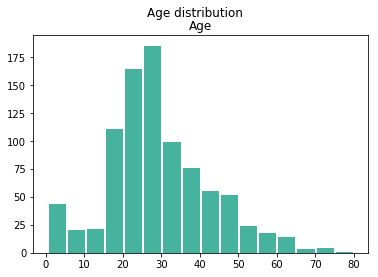

In [286]:
%matplotlib inline
import matplotlib.pyplot as plt
# Age plot
data.hist(column='Age', bins=16, grid=False, color ='#45B39D',rwidth=0.9)
plt.suptitle('Age distribution')

We notice that the majority of passengers falls between 20 and 30. Overall, the distribution seems skewed.

##### Passengers gender distribution
The next plot displays the gender of passengers.

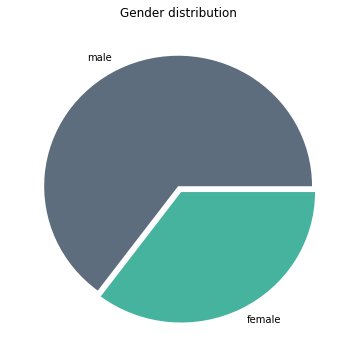

In [287]:
# Gender plot
gender = data['Sex'].value_counts()
gender.plot.pie(figsize=(6, 6), title='Gender distribution', colors=['#5D6D7E','#45B39D'], label='',explode=(0,0.05))

As we can notice, roughly about two thirds of the population are male. 

### Exploring Data
In this section, the data will be explored in order to find any hidden trends. First we will focus on surviving the incident, and how it might be connected to other factors. After that, we will look into other correlations.
### 1. Can you survive the Titanic ?
We'll investigate many factors to see if there's any noticeable correlations.
##### Is it easier to survive alone? 
Here, I had a question about how survival can be related to traveling alone vs with family. 

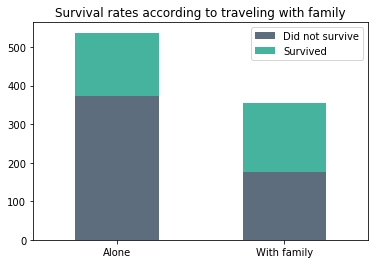

In [288]:
import seaborn as sns

#Pre-processing 
def rename_alone (field):
    if (str(field) == 'True'):
        return 'Alone'
    else:
        return 'With family'

def rename_Survived (field):
    if (str(field) == 'True'):
        return 'Survived'
    else:
        return 'Did not survive'

alone = data['alone'].apply(rename_alone)
survived = data['Survived'].apply(rename_Survived)

family = pd.crosstab(index= alone, columns= survived)
# Fix the column names
family.columns = ['Did not survive' , 'Survived'] 

family.plot.bar(stacked=True, color=['#5D6D7E','#45B39D'], rot=0, title= 'Survival rates according to traveling with family').set_xlabel('')


As we can notice, travelers with families had an equal chance of survivng as roughly have have survived while the other half couldn't. In the other hand, the distribution in passengers who traveled alone was drastically different. The plot shows a possible correlation between traveling alone and not survivng. To investigate further, we'll use a built-in function to find the correlation through Pearson's r. 

In [289]:
print ("correlation \n"+str(np.corrcoef(data['alone'],data['Survived'])[0]))

correlation 
[ 1.         -0.20336709]


Pearson's r value is too small to indicate a correlation between the two, but as we stated earlier it was negative. 
##### Class and survival, are they related ?
To answer that, we are going to use the same technique as above with similar plot. 

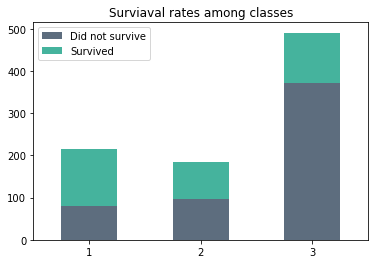

In [290]:
Class = pd.crosstab(index= data['Pclass'], columns= survived)
# Fix the column names
Class.columns = ['Did not survive' , 'Survived'] 

Class.plot.bar(stacked=True, color=['#5D6D7E','#45B39D'], title= 'Surviaval rates among classes', rot=0).set_xlabel('')


As might be expected, there seems to be a relation between the social class and the chance of surviving. In the highest class (1), about two thirds of the passengers survived, whereas in the passengers with the lowest class (3) there's the opposite situation with roughly only one quarter surviving. 

In [291]:
print ("correlation \n"+str(np.corrcoef(data['Pclass'],data['Survived'])[0]))

correlation 
[ 1.         -0.33848104]


A higher positive correlation appeared here between the class and the survival rates. 
##### What about age and gender ?
Finaly, we'll explore age and gender to see if there's any relation between them and surviving.

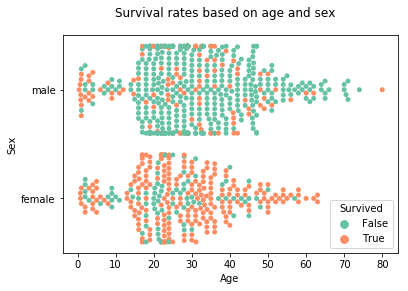

In [292]:
sns.swarmplot(x='Age', y='Sex', hue='Survived', data=data, palette='Set2')
plt.suptitle('Survival rates based on age and sex')

The previous plot shows a noticeable difference between the survival rates in women passengers compared to men. Moreover, Children under the age of 10 have higher survival rates. We can conclude that gender has a positive correlation with surviving beside being under the age of 10. 
### 2. Aside from surviving the tragedy, what else can we discover ?
Here, we'll try to explore the data to find any interesting patterns. 
##### Age and class 
How is the age of each class distributed ?

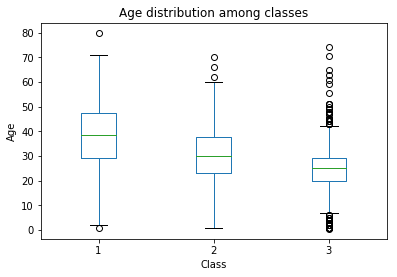

In [293]:
plot = data.boxplot(by='Pclass', column='Age', grid= False )
plot.set_xlabel('Class')
plot.set_ylabel('Age')
plot.set_title('Age distribution among classes')
plot.get_figure().suptitle('')
plot

The box representing the highest class seems to be the widest and does not contain any outliers which means age varies a lot among this class beside having the majority lying in the range from 30s to 50s. In contrast, the other two classes seems more compact and has lower median in the 30s. 
##### What about class and gender ?

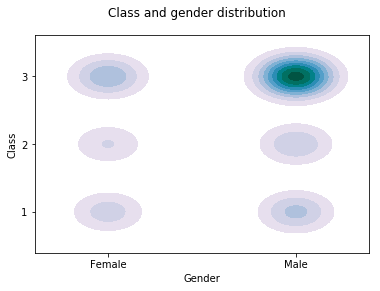

In [294]:
data['gender'] = data['Sex'] == 'male'
class_plot = sns.kdeplot(data= data['gender'], data2= data['Pclass'], yticks=[] ,cmap='PuBuGn', shade=True, legend =False, shade_lowest=False)
class_plot.set_xticks([0,1])
class_plot.set_yticks([1,2,3])
class_plot.set_xticklabels(['Female','Male'])
class_plot.set_xlabel('Gender')
class_plot.set_ylabel('Class')
plt.suptitle('Class and gender distribution')

The above plot illustrates the density of each gender across the different classes. For the the first and second class, we can notice that even though male passengers are more than the female ones, the difference is not huge. In contrast, the lowest class has a remarkable difference between male passengers compared to the female passengers with the same class. 
##### Finally, class, fare and port of embarkation. What can we get?

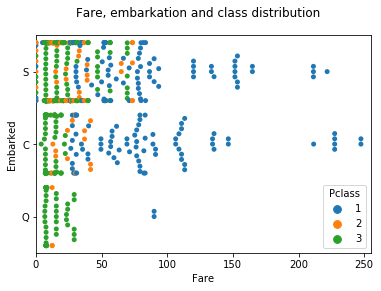

In [295]:
fare = sns.swarmplot(x='Fare', y='Embarked', data=data, hue='Pclass')
fare.set_xlim([0,255])
plt.suptitle('Fare, embarkation and class distribution')

Since we're looking into categorical data, using swarmplot is way better than using regular scatter plots like stripplot since they don't allow overlapping the dots. 
The plot gives us an overview about the passengers in terms of port of embarkation and their classes. In Southampton where the ship started its journey, the distribution of classes is roughly similar between the three classes although the second class is a bit less. This might be due to the ship ability to accommodate people with different classes (as it hasn't been filled yet). Next, Cherbourg has a similar distribution but with a noticeable difference in the second class and a huge increase in the first class. Finally, Queenstown seems to have majority of lowest class passengers. 
Fare and class were has a clear relation as the plot shows an increase in the fare with the increase in the class. 

### Conclusion
To sum up, we looked into what factors can be correlated to the survival rates, and we found that there's a slight correlation between traveling alone and not surviving the incident. Furthermore, a higher ration of higher class passengers were able to survive unlike the lowest class passengers. Finally gender seemed to be connected as females and children under the age 10 had higher chances in surviving compared to others. 
After that, we noticed that high class passengers had a higher median age compared to other classes. Whereas when looking at gender, we find an enourmous difference between the two genders in the lowest class passengers unlike other classes. Finally, and as expected, fare and class seemed to be related. 

#### Limitation 
The previous results highly depends on the quality of the data which is not guaranteed to represent the population fairly. The limited number of attributes also affected the results as it limited the considered factors when investigating. Also the data size is a bit small to derive generalized conclusions. Finally, not all variable were used or in other words, usable as some has no standard format or has too many missing values. 

#### References 
- Pandas documentation
- Seaborn documentation
- Matplotlib documentation
- Piktochart 
- Google Maps
- https://stackoverflow.com/questions/19614400/add-title-to-collection-of-pandas-hist-plots
- https://stackoverflow.com/questions/32244019/how-to-rotate-x-axis-tick-labels-in-pandas-barplot
- http://www.dataminingblog.com/standardization-vs-normalization/
- https://stackoverflow.com/questions/3459098/create-list-of-single-item-repeated-n-times-in-python
- https://stackoverflow.com/questions/41968732/set-order-of-columns-in-pandas-dataframe
- https://stackoverflow.com/questions/16472729/matrix-multiplication-in-pandas
- https://stackoverflow.com/questions/10943478/pandas-reindex-dataframe-with-datetime-objects
- https://stackoverflow.com/questions/38415048/add-subtract-dataframes-with-different-column-labels
- https://www.coursera.org/learn/ml-regression/lecture/FJcUw/k-fold-cross-validation
- https://www.coursera.org/learn/machine-learning/resources
- https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation
- https://stackoverflow.com/questions/39180873/pandas-dataframe-valueerror-num-must-be-1-num-0-not-1
